# TA Review

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Jordan Sacks
* jordansacks@uchicago.edu

### Agenda
**Homework 1 Topics**
- Solving for YTM <br>

**Homework 2 Topics**
- Discount Curve
- Duration Calculation
- Convexity Calculation
- Hedge Ratios
- Level, Slope, Curvature Factors
- PCA to Get Level, Slope, Curvature

### Libraries

In [40]:
import pandas as pd
import numpy as np
import datetime
import warnings
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

### Helper Functions

In [2]:
def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

### Data (Lets use the data from Homework #2)

In [3]:
QUOTE_DATE = '2022-03-31'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
rawprices.name = 'price'

maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
maturity_delta.name = 'maturity delta'
display(f'Treasuries quoted on {QUOTE_DATE}.')

'Treasuries quoted on 2022-03-31.'

# Solving for YTM
Let $P_j(t,T,c)$ denote the price of 
- bond $j$ 
- observed time-$t$ 
- which matures at time $T$ 
- with coupons occuring at interim cashflow dates $T_i$ for $1\le i <n$
- and a final coupon and principal payment occuring at maturity $T$.

Define the **yield-to-maturity** for bond $j$ as the term $y_j$ which satisfies the following equation:

$\begin{align*}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
\end{align*}
$

To solve for YTM, we must use a non-linear solver, such as fsolve from scipy. Using the above data, here are the following steps:
 

#### Clean Data

In [4]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, 
                         t_date=t_current, 
                         filter_yld = RESTRICT_YLD, 
                         filter_tips = RESTRICT_TIPS, 
                         drop_duplicate_maturities=RESTRICT_REDUNDANT)

In [6]:
data.head()

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207809,20220405.400000,2022-03-31,99.998194,99.998333,99.998264,M,I,0.00000,-6.944560e-07,0.000003,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207772,20220407.400000,2022-03-31,99.997181,99.997375,99.997278,M,I,0.00000,-6.111240e-06,0.000004,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207810,20220412.400000,2022-03-31,99.996500,99.996833,99.996667,M,I,0.00000,1.722309e-05,0.000003,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207784,20220414.400000,2022-03-31,99.996500,99.996889,99.996694,M,I,0.00000,2.319575e-05,0.000002,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207347,20220415.202250,2022-03-31,100.070312,100.101562,100.085938,M,I,1.03228,-5.475896e-05,0.000004,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN


#### 1. Calculate cashflows

In [5]:
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [7]:
CF.head()

,2022-04-05,2022-04-07,2022-04-12,2022-04-14,2022-04-15,2022-04-19,2022-04-21,2022-04-26,2022-04-28,2022-04-30,...,2049-11-15,2050-02-15,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207809,100,0,0,0,0.000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207772,0,100,0,0,0.000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207810,0,0,100,0,0.000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207784,0,0,0,100,0.000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207347,0,0,0,0,101.125,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2.  Calculate dirty price (include the coupon interest accrual)

In [8]:
px = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]

#### 3. Get Maturity Grid (The time difference between the maturity of the cashflows and the date of the quoted data divided by 365.25)

In [10]:
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)
maturity_grid

2022-04-05     0.013689
2022-04-07     0.019165
2022-04-12     0.032854
2022-04-14     0.038330
2022-04-15     0.041068
                ...    
2051-02-15    28.878850
2051-05-15    29.122519
2051-08-15    29.374401
2051-11-15    29.626283
2052-02-15    29.878166
Length: 313, dtype: float64

#### 4. Use fsolve to solve for YTM for each issue

In [12]:
ytm = pd.Series(index=px.index,dtype=float)
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond] = fsolve(pv_wrapper,.01)

In [14]:
ytm

KYTREASNO
207809    0.001269
207772    0.001421
207810    0.001015
207784    0.000863
207347    0.001634
            ...   
207680    0.024713
207719    0.024683
207763    0.024721
207808    0.024640
207849    0.024496
Length: 374, dtype: float64

# Discount Curve
**The discount rates are uniquely determined and can be converted to a spot curve of any compounding frequency.**

Denote the discount curve as $Z(t,T)$.

* This value depends on the maturity.
* It is not compounded. Any compounded spot rate will lead to this discount.

The discount curve is useful for multiplicative pricing.

### Zero Coupon Bond

$
\begin{align}
P_j(t,T) = Z(t,T) \times 100
\end{align}
$

### Coupon Bond

$\begin{align*}
\displaystyle P_j(t,T,c) = \sum_{i=1}^{n-1} 100 Z(t,T_i)\frac{c}{2} + 100 Z(t,T)\left(1+\frac{c}{2}\right)
\end{align*}
$

#### Assumptions
- Flat term structure equal to the rate

In [16]:
RATE = .02

#### 1. Calculate the Discount Factors
$\displaystyle\text{discount} \equiv \; Z(t,T) = \frac{1}{\left(1+\frac{r_n}{n}\right)^{n(T-t)}} \; = e^{-r(T-t)}$

In [17]:
discount_factors = np.exp(-RATE * maturity_grid)

#### Plot

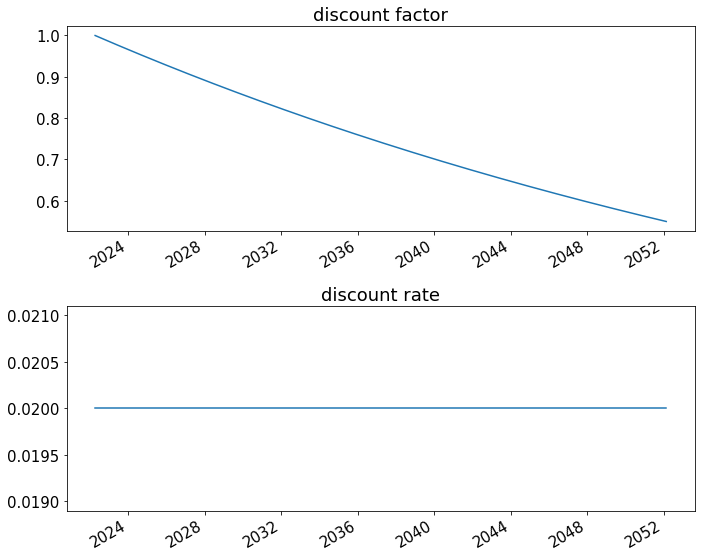

In [18]:
curves = pd.DataFrame(discount_factors,index=CF.columns, columns=['discount factor'])
curves['discount rate'] = RATE

fig,ax = plt.subplots(2,1,figsize=(10,8))
curves['discount factor'].plot(ax=ax[0],title='discount factor');
curves['discount rate'].plot(ax=ax[1],title = 'discount rate');
plt.tight_layout()

# Duration
**Duration** refers to the sensitivity of a bond (or other fixed-income product) to the **level of interest rates**.

Rather than measure sensitivity to the 3-month, 1-year, or 10-year rate, measure sensitivity to a parallel shift in all these rates, all else equal.

### Price approximation

If we know the duration of a fixed income asset, then we can approximate the percentage price change in response to a shift in rates. The approximation is

$\begin{align}
\frac{dP}{P} \approx -D\times dr
\end{align}$


### Duration of a zero-coupon bond

For a **zero coupon bond** this derivative has a simple solution:
$$\begin{align}
D_{\text{zero}} \equiv -\frac{1}{P(t,T,0)}\frac{dP(t,T,0)}{dr} = T-t
\end{align}$$

### Duration of a coupon bond
$$\begin{align}
D_{\text{coupon bond}} =& \sum_{i=1}^n w_i T_i
\end{align}$$

#### 1. Calculate the weights (assume coupon bonds)
This essentially means to discount the cashflows to present day and identify the percentage each cash flow is of the total cash flows of the bond

In [20]:
wts = CF.mul(curves['discount factor'],axis=1)
wts = wts.div(wts.sum(axis=1),axis=0)
wts.tail()

,2022-04-05,2022-04-07,2022-04-12,2022-04-14,2022-04-15,2022-04-19,2022-04-21,2022-04-26,2022-04-28,2022-04-30,...,2049-11-15,2050-02-15,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.005518,0.000000,0.005464,0.000000,0.582358,0.000000,0.000000,0.000000,0.000000
207719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006275,0.000000,0.006213,0.000000,0.006151,0.000000,0.518932,0.000000,0.000000,0.000000
207763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.005724,0.000000,0.005668,0.000000,0.005611,0.000000,0.561133,0.000000,0.000000
207808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005522,0.000000,0.005468,0.000000,0.005413,0.000000,0.005360,0.000000,0.571268,0.000000
207849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.006097,0.000000,0.006037,0.000000,0.005977,0.000000,0.005918,0.000000,0.526615


#### 2. Multiply the weights by the maturity and sum for all cash flow components

In [21]:
duration = (wts @ maturity_grid.to_frame()).rename(columns={0:'duration'})
duration.tail()

,duration
KYTREASNO,
207680,22.260200
207719,21.357805
207763,22.290829
207808,22.576822
207849,22.094494


# Convexity
Duration approximates the bond's price change with a linear approximation, (the first derivative.)

This approximation is good for small changes in the rate, but it is inadequate for larger changes.

Accordingly, we may find a second-order approximation beneficial.

This second-order term is known as the **convexity** of the bond.

## Price approximation

$\begin{align}
\frac{dP}{P} \approx -D\times dr + \frac{1}{2}C\times (dr)^2
\end{align}$

where $C$ denotes the convexity of the bond,

$\begin{align}
C \equiv & \frac{1}{P}\frac{d^2P}{dr^2}
\end{align}$


## Zero coupon bond

For a zero-coupon bond, one can show that the convexity is

$\begin{align}
C =& \frac{1}{P(t,T,0)}\frac{d^2P(t,T,0)}{dr^2}\\
=& (T-t)^2
\end{align}$


## Coupon bonds

Again, we rely on the result that a coupon bond may be decomposed as a portfolio of zero-coupon bonds (STRIPS).

For a portfolio with weights $w_i$ in securities each with convexity, $C_i$, we have,

$\begin{align}
C = \sum_{i=1}^n w_iC_i
\end{align}$

Then for a coupon bond with cashflows at times $T_i$, we once again decompose it as follows,

$\begin{align}
C =& \sum_{i=1}^n w_i(T_i-t)^2\\
\end{align}$

where these are the same weights used for the coupon bond duration calculation.

#### 1. Calculate Weights (same weights calculated in the duration calculation)

#### 2. Calculate using the formula for coupon bonds

In [22]:
duration['convexity'] = wts @ maturity_grid**2

duration.tail()

,duration,convexity
KYTREASNO,,
207680,22.260200,584.407638
207719,21.357805,554.338149
207763,22.290829,591.275475
207808,22.576822,606.478908
207849,22.094494,589.296127


# Hedge Ratios
Suppose you are building a trade to go long $n_i$ bonds and short $n_j$ notes.

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$


#### Get Data

In [27]:
filepath_tsdata = '../data/treasury_ts_issue_duration_(207392, 207391, 207457).xlsx'

info = pd.read_excel(filepath_tsdata,sheet_name='info').set_index('kytreasno')

# Homework 2 assumptions
SIZE = 10000
IDLONG = 207391
IDSHORT = 207392

FREQ = 365

# Import Data
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()

tsdata.head()

,KYTREASNO,KYCRSPID,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,TDDURATN,TDPUBOUT,TDTOTOUT,TDPDINT,TDIDXRATIO,TDIDXRATIO_FLG
0,207457,2.022122e+07,2021-10-14,101.718750,101.757812,101.738281,M,I,0.537227,0.000120,0.000004,422.648564,27118.0,38000.0,0.0,NaN,NaN
1,207457,2.022122e+07,2019-12-10,99.859375,99.898438,99.878906,M,I,0.000000,NaN,0.000045,1079.148111,NaN,NaN,0.0,NaN,NaN
2,207457,2.022122e+07,2019-12-11,99.984375,100.023438,100.003906,M,I,0.000000,0.001252,0.000044,1078.163983,NaN,NaN,0.0,NaN,NaN
3,207457,2.022122e+07,2019-12-12,99.812500,99.851562,99.832031,M,I,0.000000,-0.001719,0.000046,1077.140728,NaN,NaN,0.0,NaN,NaN
4,207457,2.022122e+07,2019-12-13,99.984375,100.023438,100.003906,M,I,0.000000,0.001722,0.000044,1076.162820,NaN,NaN,0.0,NaN,NaN


#### Get Price and Duration

In [28]:
px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()/FREQ

#### Create Dataframe that Tracks Positions

In [29]:
position = pd.DataFrame(index=duration.index, dtype=float)

position['long'] = SIZE / px[IDLONG]

#### Calculate Hedge Ratio
$$ \frac{D_{\$,i}}{D_{\$,j}} = \frac{Duration_{i}}{Duration_{j}} \cdot \frac{Price_{i}}{Price_{j}}$$

In [30]:
position['hedge ratio'] = (duration[IDLONG] / duration[IDSHORT]) * (px[IDLONG] / px[IDSHORT])

In [33]:
position['hedge ratio']

CALDT
2019-12-10    0.406667
2019-12-11    0.404369
2019-12-12    0.409461
2019-12-13    0.405647
2019-12-16    0.407493
                ...   
2022-05-24    0.374904
2022-05-25    0.374446
2022-05-26    0.377306
2022-05-27    0.375469
2022-05-31    0.380106
Name: hedge ratio, Length: 621, dtype: float64

#### Create hedged position

In [31]:
position['short'] = - position['hedge ratio'] * position['long']

#### Calculate Market Values

In [34]:
position[['long ($)','short ($)']] = position[['long','short']] * px[[IDLONG,IDSHORT]].values

position['net ($)'] = position[['long ($)','short ($)']].sum(axis=1)
position.head()

,long,hedge ratio,short,long ($),short ($),net ($)
CALDT,,,,,,
2019-12-10,101.967657,0.406667,-41.466870,10000.0,-4132.432723,5867.567277
2019-12-11,101.514791,0.404369,-41.049411,10000.0,-4125.145093,5874.854907
2019-12-12,102.424582,0.409461,-41.938828,10000.0,-4138.838061,5861.161939
2019-12-13,101.789264,0.405647,-41.290523,10000.0,-4127.761953,5872.238047
2019-12-16,102.195609,0.407493,-41.643979,10000.0,-4131.538194,5868.461806


#### Check Hedge

In [36]:
wts = position[['long ($)','short ($)']].div(position[['long ($)','short ($)']].sum(axis=1),axis=0)
position['duration'] = (wts * duration[[IDLONG,IDSHORT]].values).sum(axis=1)
position['duration'].describe().to_frame().T.style.format('{:.1%}')

,count,mean,std,min,25%,50%,75%,max
duration,62100.0%,-0.0%,0.0%,-0.0%,-0.0%,0.0%,0.0%,0.0%


# Level, Slope, Curvature
$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

In [63]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)
yields.head()

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018


In [64]:
shapes = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes['slope'] = yields[30]-yields[1]
shapes['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

DATETHRESH = '2010-01-01'
shapesT = shapes[shapes.index>DATETHRESH]

In [65]:
shapes.corr()

,level,slope,curvature
level,1.000000,-0.407054,-0.205379
slope,-0.407054,1.000000,0.623922
curvature,-0.205379,0.623922,1.000000


# PCA
PCA gives linear combinations of interest rates along the curve which have maximum explanatory power in its variation.

The factors are orthogonal to each other.

They explain decreasing amounts of variance.
* Given the high correlation across these rates, PCA can explain most the total variation with a single factor.


In [66]:
pca = PCA(svd_solver='full', n_components = 3)
pca.fit(yields)

pca_factors = pd.DataFrame(pca.transform(yields), 
                           columns=['pca.f{}'.format(i+1) for i in range(pca.n_components_)], 
                           index=yields.index)
pca_factors.head()

,pca.f1,pca.f2,pca.f3
caldt,,,
1961-06-14,-5.077413,-0.767601,-0.273407
1961-06-15,-5.015329,-0.751431,-0.316192
1961-06-16,-5.008527,-0.746056,-0.319941
1961-06-19,-4.973816,-0.733860,-0.346029
1961-06-20,-4.984028,-0.728106,-0.306213


### Loadings

In [67]:
maturities = pd.DataFrame({'maturities':[i for i in yields.columns]})
pca_loadings = pd.DataFrame(pca.components_)
pca_loadings = pca_loadings.transpose()
pca_loadings.columns = ['pca.l{}'.format(i+1) for i in range(pca.n_components_)]
pca_loadings = maturities.join(pca_loadings)
pca_loadings

,maturities,pca.l1,pca.l2,pca.l3
0,1,0.414006,-0.579680,0.470428
1,2,0.412798,-0.395445,0.015420
2,5,0.392748,-0.054039,-0.391563
3,7,0.377606,0.077522,-0.450435
4,10,0.362126,0.193496,-0.367739
5,20,0.342820,0.451925,0.345818
6,30,0.335705,0.506939,0.409175


### Correlation of PCA Factors
By definition, they are orthongonal

In [68]:
pca_factors.corr()

,pca.f1,pca.f2,pca.f3
pca.f1,1.000000e+00,-1.435615e-15,4.906242e-15
pca.f2,-1.435615e-15,1.000000e+00,6.432474e-16
pca.f3,4.906242e-15,6.432474e-16,1.000000e+00


### Predicting Rates Using PCA Model

In [77]:
model = pd.DataFrame(index = yields.index)
for i in range(len(yields.columns)):
    model[yields.columns[i]] = pca_factors.apply(lambda x:
                                                 (x*pca_loadings.iloc[i,1:].values).sum() + yields.mean().to_list()[i],
                                                 axis=1)


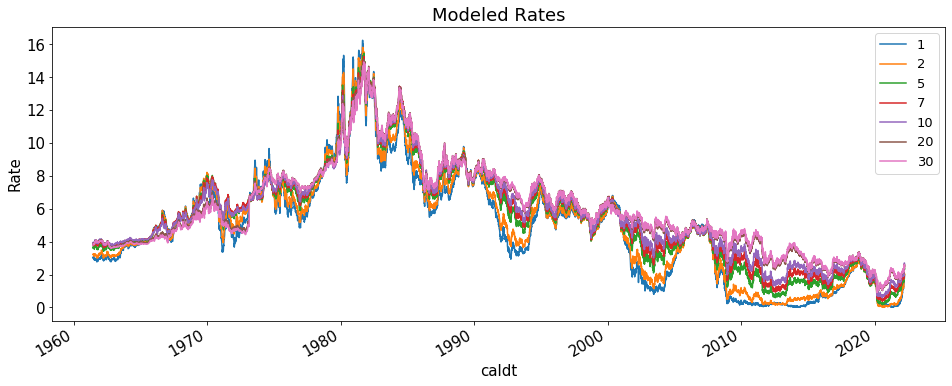

In [80]:
model.plot(figsize=(16, 6))
plt.title("Modeled Rates")
plt.ylabel("Rate")
plt.show();

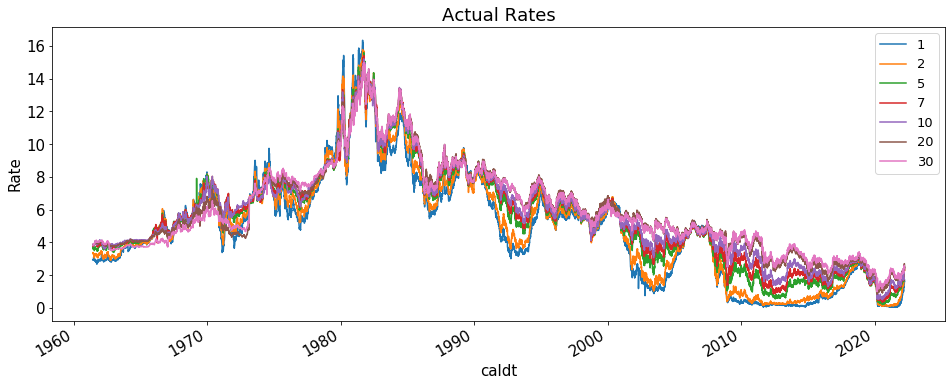

In [81]:
yields.plot(figsize=(16, 6))
plt.title("Actual Rates")
plt.ylabel("Rate")
plt.show();

***